In [5]:
%pip install pafy

In [6]:
%pip install youtube_dl

In [7]:
!pip uninstall -y debugpy

In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1903676194.py", line 8, in <cell line: 0>
    import tensorflow as tf
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/__init__.py", line 49, in <module>
    from tensorflow._api.v2 import __internal__
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/_api/v2/__internal__/__init__.py", line 13, in <module>
    from tensorflow._api.v2.__internal__ import feature_column
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/_api/v2/__internal__/feature_column/__init__.py", line 8, in <module>
    from tensorflow.python.feature_column.feature_column_v2 import DenseColumn # line: 1777
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/feature_column/feature

TypeError: object of type 'NoneType' has no len()

In [2]:
# %%capture

# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# !unrar x UCF50.rar

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# plt.figure(figsize=(20, 20))

# all_classes_names = os.listdir('UCF50')
# ransom_range = random.sample(range(len(all_classes_names)), 20)

# for counter, random_index in enumerate(ransom_range, 1):
#     selected_class_name = all_classes_names[random_index]
#     video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')
#     selected_video_file_name = random.choice(video_files_names_list)

#     video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
#     _, bgr_frame = video_reader.read()

#     video_reader.release()

#     rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

#     plt.subplot(5, 4, counter)
#     plt.imshow(rgb_frame)
#     plt.title(f"{counter}: {selected_class_name}")
#     plt.axis('off')

In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUNCE_LENGTH = 20
DATASET_DIR = 'UCF50'
CLASS_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [4]:
def frame_extraction(video_path):
  frame_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUNCE_LENGTH), 1)

  for frame_counter in range(SEQUNCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frame_list.append(normalized_frame)

  video_reader.release()
  return frame_list

In [7]:
def create_dataset(output_path):
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASS_LIST):
    print(f"extracting: {class_name}")

    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      vide_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      frames = frame_extraction(vide_file_path)
      if len(frames) == SEQUNCE_LENGTH:
        features.append(frames)
        labels.append(class_index) # Changed to class_index
        video_files_paths.append(vide_file_path)

  features = np.asarray(features)
  labels = np.asarray(labels)
  video_files_paths = np.asarray(video_files_paths)

  os.makedirs(output_path, exist_ok=True)
  np.save(os.path.join(output_path, 'features.npy'), features)
  np.save(os.path.join(output_path, 'labels.npy'), labels)
  np.save(os.path.join(output_path, 'video_files_paths.npy'), video_files_paths)

  return features, labels, video_files_paths

In [8]:
features, labels, video_file_paths = create_dataset("/content/drive/MyDrive/dataset_out")

extracting: WalkingWithDog
extracting: TaiChi
extracting: Swing
extracting: HorseRace


In [5]:
features = np.load("/content/drive/MyDrive/dataset_out/features.npy")
labels = np.load("/content/drive/MyDrive/dataset_out/labels.npy")
video_file_paths = np.load("/content/drive/MyDrive/dataset_out/video_files_paths.npy")

In [6]:
features.shape, labels.shape, video_file_paths.shape

((487, 20, 128, 128, 3), (487,), (487,))

In [7]:
one_hot_encoded_labels = to_categorical(labels)

In [8]:
one_hot_encoded_labels[:5]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [9]:
video_file_paths

array(['UCF50/WalkingWithDog/v_WalkingWithDog_g20_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g04_c02.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g22_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g11_c01.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g09_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g08_c03.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g20_c01.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g21_c01.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g04_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g10_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g03_c05.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g25_c02.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g11_c03.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g22_c01.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g05_c04.avi',
       'UCF50/WalkingWithDog/v_WalkingWithDog_g24_c05.avi',
       'UCF50/WalkingWithDog/v_WalkingWi

---

## Splitting Data

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size = 0.25,
    shuffle = True,
    random_state = seed
)

In [11]:
features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

((365, 20, 128, 128, 3), (122, 20, 128, 128, 3), (365, 4), (122, 4))

---

## ConvLSTM model


In [12]:
from warnings import filters
def create_convlstm_model():
  model = Sequential()

  model.add(ConvLSTM2D(
      filters = 32,
      kernel_size = (3, 3),
      activation = 'relu',
      data_format = 'channels_last',
      recurrent_dropout = 0.1,
      return_sequences = True,
      input_shape = (SEQUNCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(
      pool_size = (1, 2, 2),
      padding = "same",
      data_format = "channels_last"
  ))
  model.add(TimeDistributed(
      Dropout(0.2)
  ))
  # -----------------------------
  model.add(ConvLSTM2D(
      filters = 64,
      kernel_size = (3, 3),
      activation = 'relu',
      data_format = 'channels_last',
      recurrent_dropout = 0.1,
      return_sequences = True,
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  model.add(BatchNormalization()),
  model.add(MaxPooling3D(
      pool_size = (1, 2, 2),
      padding = "same",
      data_format = "channels_last"
  ))
  model.add(TimeDistributed(
      Dropout(0.2)
  ))
  # ------------------------------
  model.add(ConvLSTM2D(
      filters = 128,
      kernel_size = (3, 3),
      activation = 'relu',
      data_format = 'channels_last',
      recurrent_dropout = 0.15,
      return_sequences = True,
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  BatchNormalization(),
  model.add(MaxPooling3D(
      pool_size = (1, 2, 2),
      padding = "same",
      data_format = "channels_last"
  ))
  model.add(TimeDistributed(
      Dropout(0.2)
  ))
  # ----------------------------------
  model.add(ConvLSTM2D(
      filters = 64,
      kernel_size = (3, 3),
      activation = 'relu',
      data_format = 'channels_last',
      recurrent_dropout = 0.2,
      dropout = 0.2,
      return_sequences = False,
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling2D())

  model.add(Dense(
      256,
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  model.add(Dropout(0.5))

  model.add(Dense(
      128,
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(0.001)
  ))
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(
      len(CLASS_LIST),
      activation='softmax'
  ))

  # model.summary()

  return model

In [13]:
def compile_prep_model(model, lr=0.001):
  optimizer = Adam(
      learning_rate= lr,
      beta_1= 0.9,
      beta_2= 0.999,
      epsilon= 1e-7
  )

  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy', 'top_k_categorical_accuracy']
  )

  callbacks = [
      EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
  ]
  return model, callbacks

In [14]:
model = create_convlstm_model()
model, callbacks = compile_prep_model(model)

model.summary()

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 126, 126,   │        40,448 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 126, 126,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 63, 63, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 61, 61, 64) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 61, 61, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 31, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 31, 31, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 29, 29,     │       885,248 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 15, 15,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 15, 15,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 13, 13, 64)     │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           51

 Total params: 1,640,452 (6.26 MB)

 Trainable params: 1,640,132 (6.26 MB)

 Non-trainable params: 320 (1.25 KB)

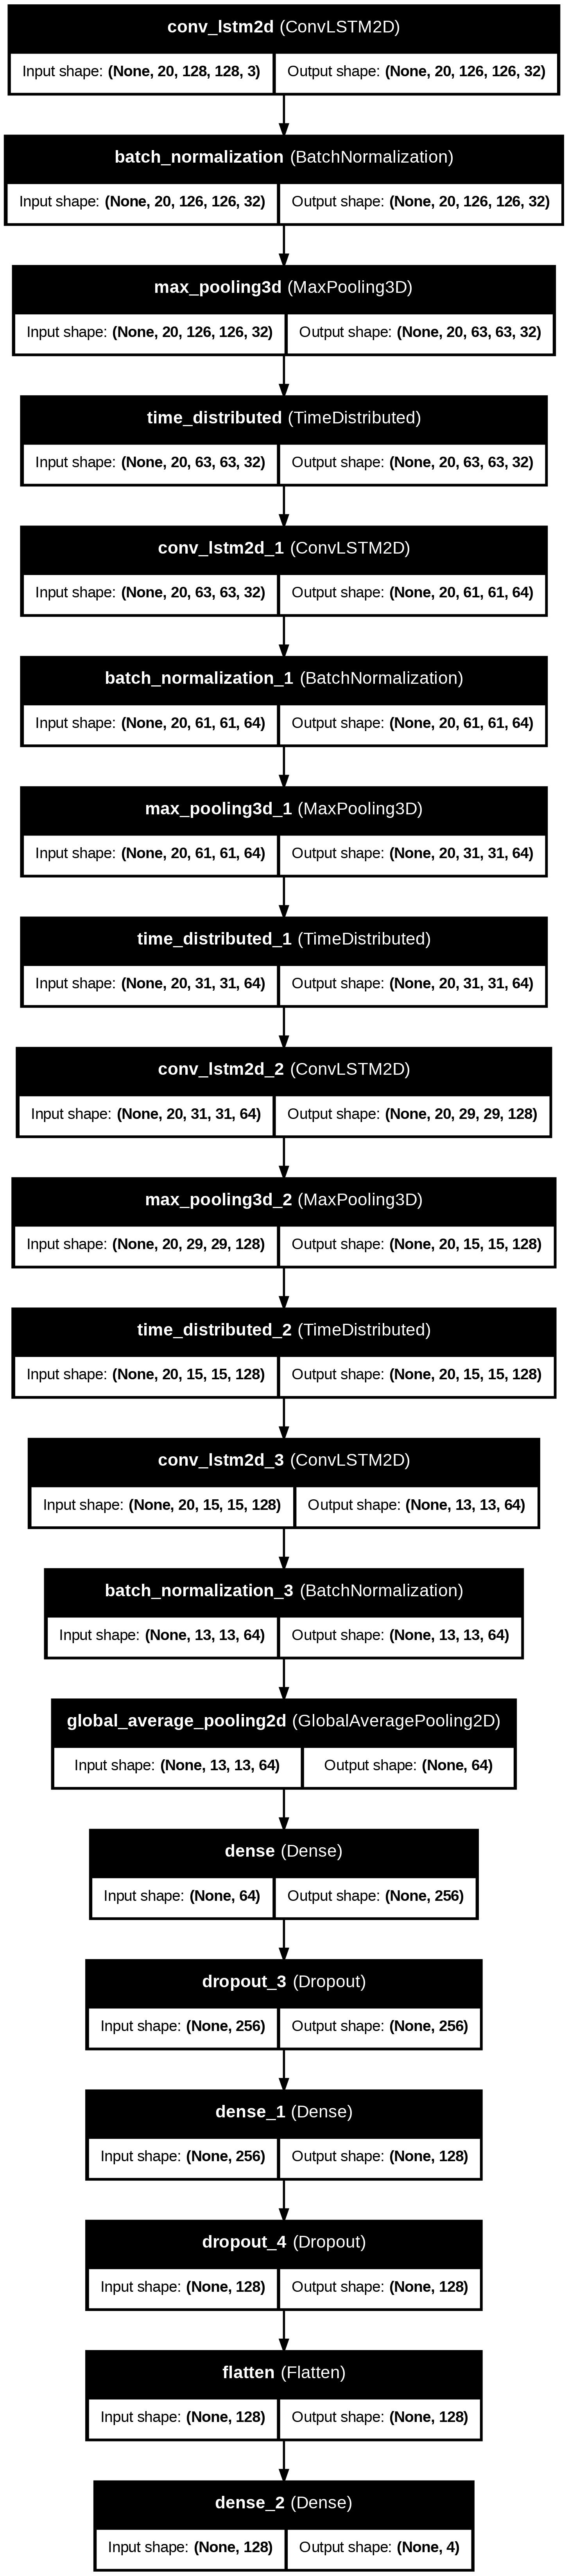

In [15]:
# plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    features_train,
    labels_train,
    validation_data = (features_test, labels_test),
    epochs = 50,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    callbacks = callbacks
)